In [1]:
from db import Database
import processing as proc
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import sklearn

logger = proc.setupLog()
figureCount = 0

In [2]:

#format for graphs to work with dark themed notebook
COLOR = 'white'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
#end formatting
records = Database("bank_data")
smallerTable = "people"
largerTable = "people_additional"
print(records.getEntries('people',0,1))
print(records.getSize("people"))
"""
TABLE people (
id INT AUTO_INCREMENT,
age TINYINT,
job CHAR(1),
maritial CHAR(1),
education CHAR(1),
isDefault CHAR(1),
balance INT,
housing CHAR(1),
loan CHAR(1),
contact CHAR(1),
day TINYINT,
month TINYINT,
duration SMALLINT,
campaign TINYINT,
pdays SMALLINT,
previous SMALLINT,
poutcome CHAR(1),
y CHAR(1),
"""

Connected to db
Successful SQL commands are printed on execution.
USE bank_data
(58, 'M', 'M', 'T', 'N', 2143, 'Y', 'N', '?', 5, 5, 261, 1, -1, 0, '?', 'N')
90422


'\nTABLE people (\nid INT AUTO_INCREMENT,\nage TINYINT,\njob CHAR(1),\nmaritial CHAR(1),\neducation CHAR(1),\nisDefault CHAR(1),\nbalance INT,\nhousing CHAR(1),\nloan CHAR(1),\ncontact CHAR(1),\nday TINYINT,\nmonth TINYINT,\nduration SMALLINT,\ncampaign TINYINT,\npdays SMALLINT,\nprevious SMALLINT,\npoutcome CHAR(1),\ny CHAR(1),\n'

In [3]:
#first just examine frequency of 'y'
numPeople = records.getSize('people')
numPeopleAdditional = records.getSize('people_additional')
peopleOut = records.getEntriesByField('people',0,numPeople,'y')
peopleAdditionalOut = records.getEntriesByField('people_additional',0,numPeopleAdditional,'y')

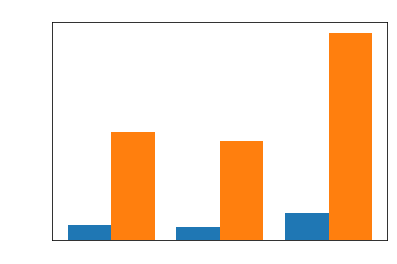

In the abbreviated dataset a purchase occured 11.70% of the time.
In the full dataset a purchase occured 11.27% of the time.
In the combined dataset a purchase occured 11.49% of the time.


In [4]:
#print out buying frequency
peopleBuy = 0

for char in peopleOut:
    if char == 'Y': peopleBuy+=1
peopleAdditionalBuy = 0
for char in peopleAdditionalOut:
    if char == 'Y': peopleAdditionalBuy+=1

buys = (peopleBuy,peopleAdditionalBuy,peopleBuy+peopleAdditionalBuy)
notBuys = (numPeople-buys[0],numPeopleAdditional-buys[1],numPeople+numPeopleAdditional-buys[2])

ind = [ i for i in range(3)]
width = .4
plt.figure(figureCount)
figureCount+=1
plt.bar(ind,buys,width,label= 'Purchase')
plt.bar([item+width for item in ind],notBuys,width,label='No Purchase')
plt.title('Purchase frequency by dataset')
plt.xticks([item+width/2 for item in ind],('abbreviated dataset','full dataset', 'overall'))
#plt.legend(loc='best')
plt.show()

print("In the abbreviated dataset a purchase occured {:.2f}% of the time.".format(
     ( float(buys[0])/float(numPeople) )*100 ) )
print("In the full dataset a purchase occured {:.2f}% of the time.".format(
     ( float(buys[1])/float(numPeopleAdditional) )*100 ) )
print("In the combined dataset a purchase occured {:.2f}% of the time.".format(
     ( float(buys[2])/float(numPeople+numPeopleAdditional) )*100 ) )


In [5]:
#get data dictionaries for processing
peopleMap, peopleAdditionalMap = records.getMaps()

In [6]:

#sql entries
line = records.getEntries('people',0,numPeople)
#translate to human-readable dataframe (similar to original csv)
df = proc.getDataFrame(line,peopleMap)
#see validate for more details, basically ensures all categories accounted for properly
proc.validate(df,peopleMap)

vec = proc.getOneHot(df,peopleMap,False)

#duration is not known until outcome is known
#see dataset documentation for more info
vec = vec.drop('duration',axis=1)
print(vec)



lineA = records.getEntries('people_additional',0,numPeopleAdditional)
dfa = proc.getDataFrame(lineA,peopleAdditionalMap)
proc.validate(dfa,peopleAdditionalMap)
#dfa = dfa.drop('duration',axis=1)
vecA = proc.getOneHot(dfa,peopleAdditionalMap,False)

vecA = vecA.drop('duration',axis=1)


#rand generator
randomGenr = np.random.default_rng()

#get cols
colTitles = vec.columns
colTitlesA = vecA.columns
#get processing array
dataOneHot = vec.to_numpy(dtype=np.float64)
dataOneHotA = vecA.to_numpy(dtype=np.float64)

##practice  run:


in processsinggg
{'y': {'yes': 1, 'no': 0}}
in processsinggg
{'y': {'yes': 1, 'no': 0}}
       age  job_management  job_blue-collar  job_entrepreneur  job_housemaid  \
0       58               1                0                 0              0   
1       44               0                0                 0              0   
2       33               0                0                 1              0   
3       47               0                1                 0              0   
4       33               0                0                 0              0   
...    ...             ...              ...               ...            ...   
90417   51               0                0                 0              0   
90418   71               0                0                 0              0   
90419   72               0                0                 0              0   
90420   57               0                1                 0              0   
90421   37               0      

In [7]:
numTrees = 1000
"""
for i in range(5):
    print('trial: {}'.format(i))
    
    #generate models
    treeModel = RandomForestClassifier(n_estimators=numTrees)
    treeModelA = RandomForestClassifier(n_estimators=numTrees)
    

    #get datasets 
    dataP = dataOneHot
    dataA = dataOneHotA
        
    #shuffle data
    randomGenr.shuffle(dataP)
    randomGenr.shuffle(dataA)
    
    #extract features, set float
    features = dataP[:,:-1].astype(np.float64)
    featuresA = dataA[:,:-1].astype(np.float64)
    
    #extract labels
    labels = dataP[:,-1]
    labelsA = dataA[:,-1]
    

    #get ~10% of indices as random choice WITHOUT replacement for test
    testIndices = randomGenr.choice(len(labels),size=int(len(labels)*.1),replace=False)
    testIndicesA = randomGenr.choice(len(labelsA),size=int(len(labelsA)*.1),replace=False)
    
    #take test items
    testLabels = np.take(labels,testIndices)
    testFeatures = np.take(features,testIndices,axis=0)
    testLabelsA = np.take(labelsA,testIndicesA)
    testFeaturesA = np.take(featuresA,testIndicesA,axis=0)

    #remove test items
    trainLabels = np.delete(labels,testIndices)
    trainFeatures = np.delete(features,testIndices,axis=0)
    trainLabelsA = np.delete(labelsA,testIndicesA)
    trainFeaturesA = np.delete(featuresA,testIndicesA,axis=0)

    #fit models
    treeModel.fit(trainFeatures,trainLabels)
    treeModelA.fit(trainFeaturesA,trainLabelsA)
 
    #get predictions
    treePredictions = treeModel.predict(testFeatures)
    treePredictionsA = treeModelA.predict(testFeaturesA)
    
    #get model probability score for predictions
    treeProbs = treeModel.predict_proba(testFeatures)
    treeProbsA = treeModel.predict_proba(testFeatures)
    
    #get feature importance, using permutation_importance (issues possible )
    bunch = permutation_importance(treeModel, testFeatures, testLabels, n_repeats=10)
    bunchA = permutation_importance(treeModelA, testFeaturesA, testLabelsA, n_repeats=10)
   

    #Save records for later processing
    #TODO: vectorize np writes
    np.save('./np/actual/actual_{}'.format(i),testLabels)
    np.save('./np/actual/actual_add_{}'.format(i),testLabelsA)
    
    np.save('./np/rafo/prediction_{}_{}'.format(i,numTrees),treePredictions)
    np.save('./np/rafo/tree_proba_{}_{}'.format(i,numTrees),treeProbs)
    
    np.save('./np/rafo/prediction_add_{}_{}'.format(i,numTrees),treePredictionsA)
    np.save('./np/rafo/tree_proba_add_{}_{}'.format(i,numTrees),treeProbsA)
    
    for key in bunch.keys():
        np.save('./np/rafo/perm_import_{}_{}'.format(i,key),bunch[key])
        np.save('./np/rafo/perm_import_add_{}_{}'.format(i,key),bunchA[key])
    for key in bunch.keys():
        print(bunch[key].shape)
        
print('done')
"""
    

"\nfor i in range(5):\n    print('trial: {}'.format(i))\n    \n    #generate models\n    treeModel = RandomForestClassifier(n_estimators=numTrees)\n    treeModelA = RandomForestClassifier(n_estimators=numTrees)\n    \n\n    #get datasets \n    dataP = dataOneHot\n    dataA = dataOneHotA\n        \n    #shuffle data\n    randomGenr.shuffle(dataP)\n    randomGenr.shuffle(dataA)\n    \n    #extract features, set float\n    features = dataP[:,:-1].astype(np.float64)\n    featuresA = dataA[:,:-1].astype(np.float64)\n    \n    #extract labels\n    labels = dataP[:,-1]\n    labelsA = dataA[:,-1]\n    \n\n    #get ~10% of indices as random choice WITHOUT replacement for test\n    testIndices = randomGenr.choice(len(labels),size=int(len(labels)*.1),replace=False)\n    testIndicesA = randomGenr.choice(len(labelsA),size=int(len(labelsA)*.1),replace=False)\n    \n    #take test items\n    testLabels = np.take(labels,testIndices)\n    testFeatures = np.take(features,testIndices,axis=0)\n    testLab

In [8]:
#TODO: vectorize np reads

forestPred = np.array([])
forestProb = np.array([])
actual = np.array([])
forestPredA = np.array([])
forestProbA = np.array([])
actualA = np.array([])
bunches = np.array([])
bunchesA = np.array([])



for i in range(5):

    if(i==0):
        actual = [np.load('./np/actual/actual_{}.npy'.format(i))]
        forestPred = [np.load('./np/rafo/prediction_{}_{}.npy'.format(i,numTrees))]
        forestProb = [np.load('./np/rafo/tree_proba_{}_{}.npy'.format(i,numTrees))]
        
        actualA = [np.load('./np/actual/actual_add_{}.npy'.format(i))]
        forestPredA = [np.load('./np/rafo/prediction_add_{}_{}.npy'.format(i,numTrees))]
        forestProbA = [np.load('./np/rafo/tree_proba_add_{}_{}.npy'.format(i,numTrees))]

    else:
        actual = np.append(actual,[np.load('./np/actual/actual_{}.npy'.format(i))],axis=0)
        forestPred = np.append(forestPred,[np.load('./np/rafo/prediction_{}_{}.npy'.format(i,numTrees))],axis=0)
        forestProb = np.append(forestProb,[np.load('./np/rafo/tree_proba_{}_{}.npy'.format(i,numTrees))],axis=0)
        
        actualA = np.append(actualA,[np.load('./np/actual/actual_add_{}.npy'.format(i))],axis=0)
        forestPredA = np.append(forestPredA,[np.load('./np/rafo/prediction_add_{}_{}.npy'.format(i,numTrees))],axis=0)
        forestProbA = np.append(forestProbA,[np.load('./np/rafo/tree_proba_add_{}_{}.npy'.format(i,numTrees))],axis=0)
    bunch = dict()
    bunchA = dict()
    for key in ['importances','importances_mean','importances_std']:
        bunch[key] = np.load('/Users/jake/proj/tele_pred/np/rafo/perm_import_{}_{}.npy'.format(i,key))
        bunchA[key] = np.load('/Users/jake/proj/tele_pred/np/rafo/perm_import_add_{}_{}.npy'.format(i,key))
    bunches = np.append(bunches,bunch)
    print(bunches.shape)
    bunchesA = np.append(bunchesA,bunchA)

(1,)
(2,)
(3,)
(4,)
(5,)


In [9]:
#might be able to base (some) vectorization of redundant stuff above off this loop
corrects = []
wrongs = []
for i in range(2):
    c = []
    #this is the probability(y=1)
    w = []
    for ac,fo,pr in zip(actual,forestPred,forestProb):
        #[trueNegative,truePositive,averageProb]
        correct = [0,0,0]
        #[falseNegative,falsePositive,averageProb]
        wrong = [0,0,0]
        for a,f,p in zip(ac,fo,pr):
            if a == f:
                correct[int(a)]+=1
                correct[2]+=p[int(f)]
            else:
                wrong[int(a)]+=1
                wrong[2]+=p[int(f)]
        
        correct[2] = correct[2]/(correct[0]+correct[1])
        wrong[2] = wrong[2]/(wrong[0]+wrong[1])
        c.append(correct)
        w.append(wrong)
    corrects.append(c)
    wrongs.append(w)

In [10]:
"""
logger.info('Duration feature has been removed for these runs:')
for co,wr in zip(corrects,wrongs):
    i=0
    for c,w in zip(co,wr):
        if i==0:
            logger.info("RUN NUMBER: {}, number of trees: {}, standard feature set".format(i,numTrees))
        else:
            logger.info("RUN NUMBER: {}, number of trees: {}, extended feature set".format(i,numTrees))
    
        logger.info("{} TRUE POSITIVES".format(c[1]))
        logger.info("{} TRUE NEGATIVES".format(c[0]))
        logger.info("{} FALSE POSITIVES".format(w[0]))
        logger.info("{} FALSE NEGATIVES".format(w[1]))
        logger.info('correct {}% of the time with average confidence={}'.format((100*(c[0]+c[1])/(w[0]+w[1]+c[0]+c[1])),c[2]))
        logger.info('wrong {}% of the time with average confidence={}'.format((100*(w[0]+w[1])/(w[0]+w[1]+c[0]+c[1])),w[2]))
        logger.info('\n---')
        i+=1
 """   
        

'\nlogger.info(\'Duration feature has been removed for these runs:\')\nfor co,wr in zip(corrects,wrongs):\n    i=0\n    for c,w in zip(co,wr):\n        if i==0:\n            logger.info("RUN NUMBER: {}, number of trees: {}, standard feature set".format(i,numTrees))\n        else:\n            logger.info("RUN NUMBER: {}, number of trees: {}, extended feature set".format(i,numTrees))\n    \n        logger.info("{} TRUE POSITIVES".format(c[1]))\n        logger.info("{} TRUE NEGATIVES".format(c[0]))\n        logger.info("{} FALSE POSITIVES".format(w[0]))\n        logger.info("{} FALSE NEGATIVES".format(w[1]))\n        logger.info(\'correct {}% of the time with average confidence={}\'.format((100*(c[0]+c[1])/(w[0]+w[1]+c[0]+c[1])),c[2]))\n        logger.info(\'wrong {}% of the time with average confidence={}\'.format((100*(w[0]+w[1])/(w[0]+w[1]+c[0]+c[1])),w[2]))\n        logger.info(\'\n---\')\n        i+=1\n '

in processsinggg
{'y': {'yes': 1, 'no': 0}}
	Feature importance for abbreviated dataset:


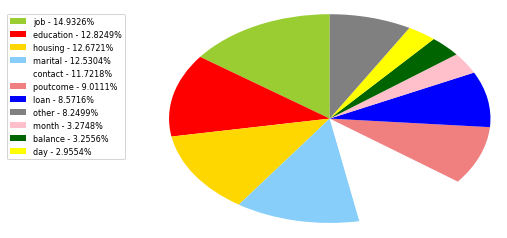

other feautures :
age - 2.8193%
campaign - 2.3531%
isDefault - 2.2505%
previous - 0.6232%
pdays - 0.2037%


	Feature importance for dataset with all features:
in processsinggg
{'y': {'yes': 1, 'no': 0}}


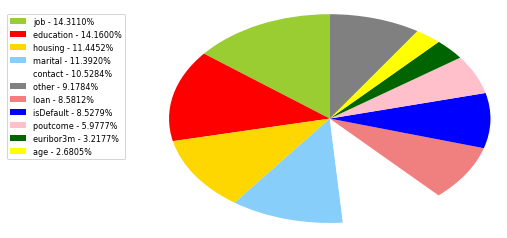

other feautures :
campaign - 2.1185%
day_of_week - 2.0924%
nr.employed - 1.1050%
emp.var.rate - 1.0774%
cons.price.idx - 0.8567%
cons.conf.idx - 0.7195%
month - 0.7144%
previous - 0.3122%
pdays - 0.1822%


In [11]:
cols = colTitles[:-1]
colsA = colTitlesA[:-1]

#returns labels,means,rest - labels and means are top~90% of importances, and rest is rest
result = proc.processImportance(peopleMap,cols,bunches[0])
print('\tFeature importance for abbreviated dataset:')
proc.pie(result[0],result[1],result[2],figureCount)
figureCount+=1
print('\n\n\tFeature importance for dataset with all features:')
resultA = proc.processImportance(peopleAdditionalMap,colsA,bunchesA[0])
proc.pie(resultA[0],resultA[1],resultA[2],figureCount)
figureCount+=1





In [12]:
#an attempt to calcualte covariences directly resulted in kernel failure likely related to
#virtual/swap memory constraints, could even be due to firefox??
#below is a funky way of getting around it, making use of the fact that we dont actually care
#about the entire matrix, but only the covariences which involve the label
features = dataOneHot[:,:-1]
labels = dataOneHot[:,-1]

print('begin epic 🐏 saving procedure 😳')
for feature,data in zip(cols,features.T):
        pairData = np.array([labels,data])
        #print(pairData.shape)
        np.save('./np/cov/{}'.format(feature),pairData)
        cov = np.cov(pairData)
        np.save('./np/cov/{}_cov'.format(feature),cov)
print('done with abbrev')

features = dataOneHotA[:,:-1]
labels = dataOneHotA[:,-1]
for feature,data in zip(colsA,features.T):
        pairData = np.array([labels,data])
        np.save('./np/covA/{}'.format(feature),pairData)
        cov = np.cov(pairData)
        np.save('./np/covA/{}_cov'.format(feature),cov)
print('epicness complete 😂')

begin epic 🐏 saving procedure 😳
done with abbrev
epicness complete 😂


In [13]:
#correlation with output variable

#correlation with output variable for the Additional dataset

#covariences show that some catagorical data has catagoreis not ever taken.
#TODO: remove these categories from the one-hots
corr = {}
for feature in cols:
    cov = np.load('./np/cov/{}_cov.npy'.format(feature))
    if not cov[1,1] == 0:
        corr[feature] = cov[0,1]/(np.sqrt(cov[0,0])*np.sqrt(cov[1,1]))
importantFeatures = [string[:string.index(' ')] for string in result[0]]
correlations = proc.processCorrelation(peopleMap,importantFeatures,corr)

corrA = {}
for feature in colsA:
    cov = np.load('./np/covA/{}_cov.npy'.format(feature))
    if not cov[1,1] == 0:
        corrA[feature] = cov[0,1]/(np.sqrt(cov[0,0])*np.sqrt(cov[1,1]))
importantFeaturesA = [string[:string.index(' ')] for string in resultA[0]]   
correlationsA = proc.processCorrelation(peopleAdditionalMap,importantFeaturesA,corrA)




in processsinggg
{'y': {'yes': 1, 'no': 0}}
binarrrryy
dict_keys(['y'])
end of the road
in processsinggg
{'y': {'yes': 1, 'no': 0}}
binarrrryy
dict_keys(['y'])
end of the road


Correlation of features ranked as important by the model:


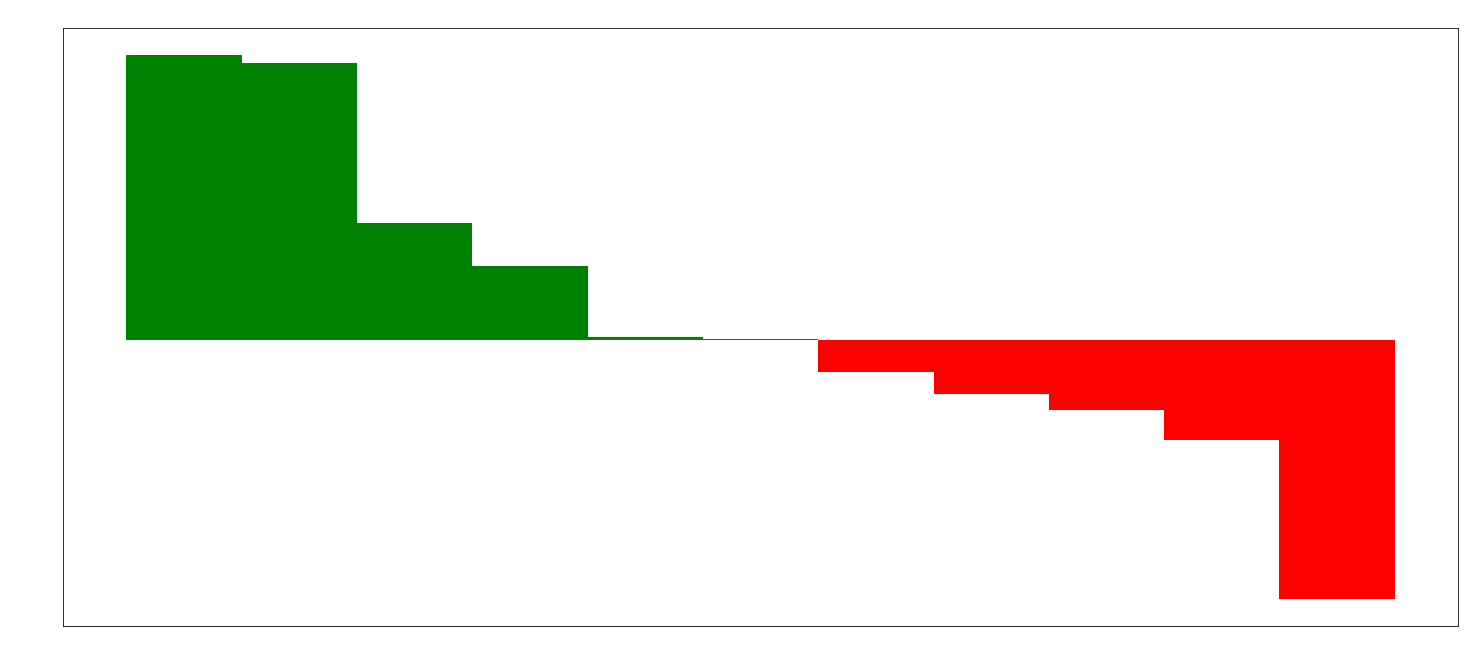

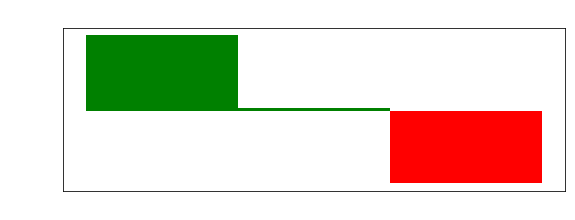

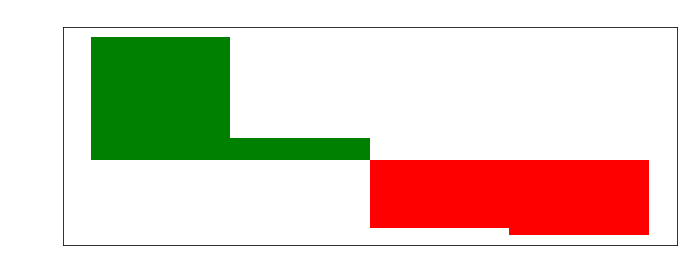

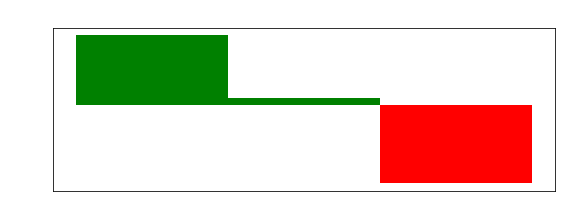

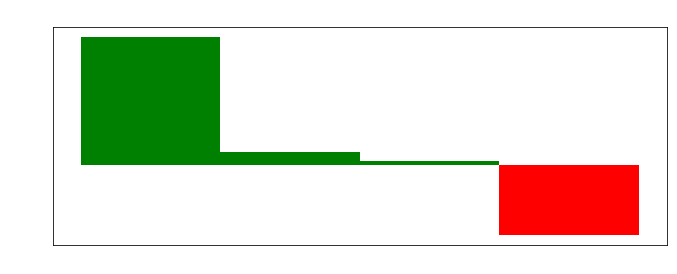

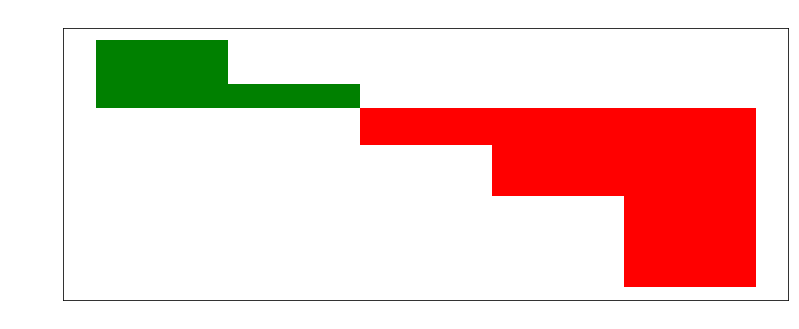

In [15]:
#format for graphs to work with dark themed notebook
COLOR = 'white'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
otherData = []
otherLabels = []
print('Correlation of features ranked as important by the model:')
for field in correlations.keys():
    if isinstance(correlations[field],dict):
        proc.bar(field,[c for c in correlations[field].values()],correlations[field].keys(),figureCount)
        figureCount+=1
    else:
        otherData.append(correlations[field])
        otherLabels.append(field)

proc.bar('',otherData,otherLabels,figureCount,isCategorical=False)
figureCount+=1


